In [1]:
%load_ext autoreload
%autoreload 2

## Saving as a scenario

In [2]:
!ls ../mat/*


../mat/line_fresnelastique.npy ../mat/line_vague_solo.npy
../mat/line_vague_dense.npy    ../mat/master.npy


In [6]:
%%writefile ../scenario_line_master.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np
import os

def master(e, filename):
    if e.structure: N_lame = e.N_lame-e.struct_N
    else: N_lame = e.N_lame

    def montage(z, z_in):
        print (z_in[0, 0], z[-1, 0], z_in[0, 0], z_in[-1, 0])
        z_in[:, 0] += z[-1, 0] + 1./e.desired_fps # increment the time on the new array
        print (z.shape, z_in.shape, z_in[0, 0], z_in[-1, 0])
        return np.vstack((z, z_in))

    
    matpath = 'mat/'
    z_s = {}
    for scenario in ['line_vague_dense', 'line_vague_solo', 'line_fresnelastique']:
        z_s[scenario] = np.load(os.path.join(matpath, scenario + '.npy'))
    
    ###########################################################################
    burnout_time = 4.
    z = np.zeros((1, N_lame+1)) # zero at zero
    z = np.vstack((z, np.hstack((np.array(burnout_time), np.zeros(N_lame) ))))
    ###########################################################################
    z = montage(z, z_s['line_vague_dense'])
    ###########################################################################
    z = montage(z, z_s['line_vague_solo'])
    ###########################################################################
    z = montage(z, z_s['line_fresnelastique'])
    ###########################################################################
    z = montage(z, z_s['line_vague_dense'])
    
    ###########################################################################
    # save the file
    np.save(filename, z)

        

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
        
    filename='mat/master.npy'
    
    e = el.EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=True, filename=filename)

    if mode == 'writer':
        master(e, filename)
    else:
        # running the code
        el.main(e)


Overwriting ../scenario_line_master.py


In [7]:
%cd ..
%run  scenario_line_master.py writer
%cd posts

/Users/laurentperrinet/pool/Dropbox/py-elasticite
0.0 4.0 0.0 19.9666666667
(2, 26) (600, 26) 4.03333333333 24.0
0.0 24.0 0.0 19.9666666667
(602, 26) (600, 26) 24.0333333333 44.0
0.0 44.0 0.0 29.9666666667
(1202, 26) (900, 26) 44.0333333333 74.0
4.03333333333 74.0 4.03333333333 24.0
(2102, 26) (600, 26) 78.0666666667 98.0333333333
/Users/laurentperrinet/pool/Dropbox/py-elasticite/posts


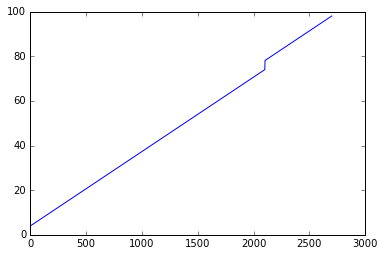

In [8]:
z = np.load('../mat/master.npy')
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(z[:, 0])

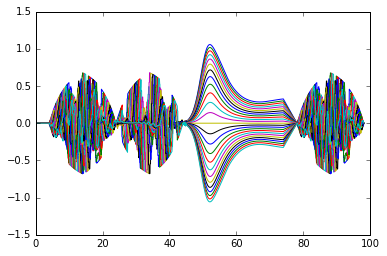

In [9]:
_ = plt.plot(z[:, 0], z[:, 1:])

## git


In [14]:
#! git add 2015-11-26*
!git s

 M "2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb"
 M ../src/elasticite.py


In [15]:
!git commit -am' scenario master '

[master 40d5dfc]  scenario master
 2 files changed, 28 insertions(+), 25 deletions(-)


In [16]:
! git push

Counting objects: 6, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 804 bytes | 0 bytes/s, done.
Total 6 (delta 4), reused 0 (delta 0)
To git@git.framasoft.org:laurentperrinet/elasticte.git
   8c507c3..40d5dfc  master -> master
